In [1]:
%load_ext autoreload
%autoreload 2

# Get parent directory and add to sys.path
import os
import sys

parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)

# Require ipympl
%matplotlib widget 

In [2]:
# MPC import
import numpy as np
from LinearMPC_template.MPCVelControl import MPCVelControl
from LinearMPC_template.MPCControl_roll import MPCControl_roll
from src.rocket import Rocket
from src.vel_rocket_vis import RocketVis

rocket_obj_path = os.path.join(parent_dir, "Cartoon_rocket.obj")

rocket_params_path = os.path.join(parent_dir, "rocket.yaml")

Subsystem x: 

Input upper bounds are [0.26179939]
Input lower bounds are [-0.26179939]
State upper bounds are [       inf 0.17453293        inf]
State lower bounds are [       -inf -0.17453293        -inf] 

Not yet convgerged at iteration 1
Not yet convgerged at iteration 2
Not yet convgerged at iteration 3
Not yet convgerged at iteration 4
Not yet convgerged at iteration 5
Not yet convgerged at iteration 6
Not yet convgerged at iteration 7
Not yet convgerged at iteration 8
Maximum invariant set found after 9 iterations !

Subsystem y: 

Input upper bounds are [0.26179939]
Input lower bounds are [-0.26179939]
State upper bounds are [       inf 0.17453293        inf]
State lower bounds are [       -inf -0.17453293        -inf] 

Not yet convgerged at iteration 1
Not yet convgerged at iteration 2
Not yet convgerged at iteration 3
Not yet convgerged at iteration 4
Not yet convgerged at iteration 5
Not yet convgerged at iteration 6
Not yet convgerged at iteration 7
Not yet convgerged at 

AppLayout(children=(HBox(children=(Play(value=0, description='Press play', max=99, step=2), IntSlider(value=0,…

AppLayout(children=(HBox(children=(Play(value=0, description='Press play', max=99, step=2), IntSlider(value=0,…

omega_x  | max abs error = 1.560e-13
omega_y  | max abs error = 1.564e-13
omega_z  | max abs error = 1.327e-29
alpha    | max abs error = 8.348e-13
beta     | max abs error = 8.350e-13
gamma    | max abs error = 5.075e-29
v_x      | max abs error = 2.109e-11
v_y      | max abs error = 2.104e-11
v_z      | max abs error = 7.432e-13


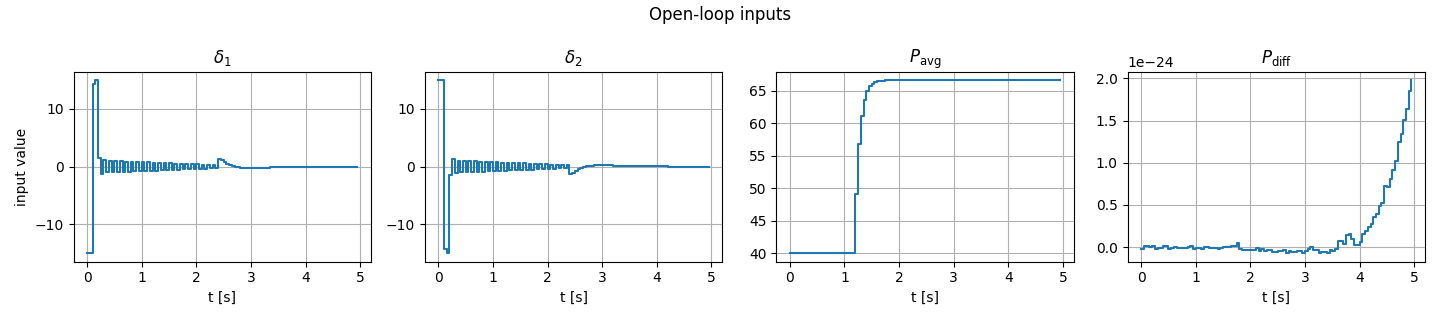

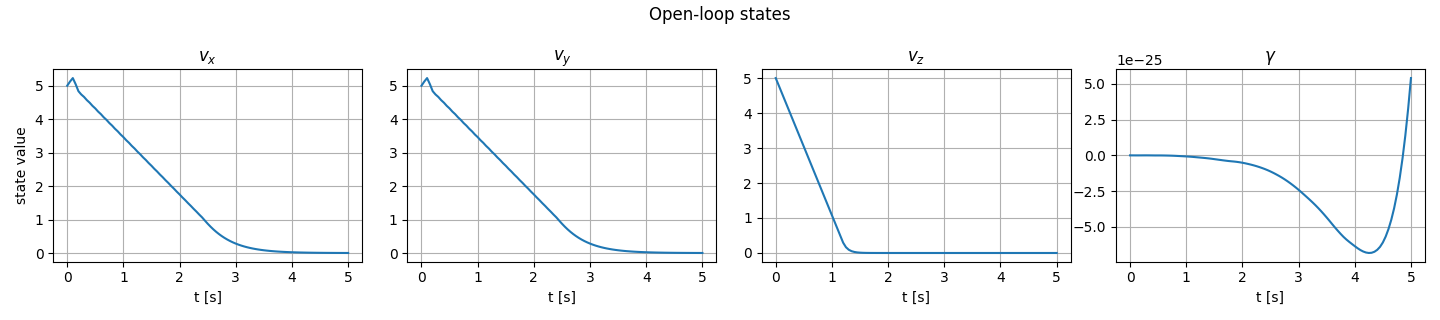

In [15]:
Ts = 0.05
sim_time = 15
H = 5
omega_x0 = 0; omega_y0 = 0; omega_z0 = 0; alpha0 = 0; beta0 = 0; gamma0 = 0; v_x0 = 5; v_y0 = 5; v_z0 = 5 # 5 m/s + no roll angle
x0 = np.array([omega_x0, omega_y0, omega_z0, alpha0, beta0, gamma0, v_x0, v_y0, v_z0])  # initial states, must not contain the positions !
t0 = 0 # initial timestamp begins at 0 seconds

rocket = Rocket(Ts=Ts, model_params_filepath=rocket_params_path)

# single sub-system open-loop trajectory
# xs, us = rocket.trim()
# A, B = rocket.linearize(xs, us)
# mpc_roll = MPCControl_roll(A, B, xs, us, Ts, H) # Full 12x12 A and 12x4 B matrices
# u0_sysr, x_ol_sysr, u_ol_sysr = mpc_roll.get_u(x0[mpc_roll.x_ids]) # x and u for single subsystem x
# print(f"x_ol has shape{x_ol_sysr.shape}")
# print(f"u_ol has shape{u_ol_sysr.shape}")
# print(f"t_ol has shape{t_ol.shape}")

# total system open-loop trajectory for non-stationnary x0:

mpc = MPCVelControl().new_controller(rocket, Ts, H)
u0_ol, x_ol, u_ol, t_ol = mpc.get_u(t0, x0, show_Xf=False)

vis = RocketVis(rocket, rocket_obj_path)
vis.anim_rate = 1.0
vis.animate(t_ol[:-1], x_ol[:, :-1], u_ol)

# Animate the open-loop predictions : previously, the positions are hard-set to 0 and the animation stays at the same place.
# If I want to compute them for animation, I can :
# 1. keep the open-loop inputs computed previously
# 2. extend x0 to having 12 states and setting initial position to 0 (but initial velocity is still 5 m/s).
# 3. use simulate_step with OPEN LOOP inputs computed at x0 as input for each timestamp
# simulate_step will compute the open-loop STATE trajectories again, but the difference is that the positions are now incldued. Because the matrices A_red and B_red used
# in each subsystem MPC are extracted from the overall linearized and discretized A and B, it's possible that the states computed previously independently for each
# subsystem (x_ol) and the newly comptued states (x_sim, full, with position added) are a bit different due to the fact that A_red deleted some possible correlations 
# between the states of one subsystem with the others. We would like to measure the error between x_ol and x_sim to confirm this USEFUL FOR 2.2.

# Roll out plant by implementing the SAME open-loop inputs as above so as to compute the state vector with positions
x0_full = np.zeros(12)
x0_full[:9] = x0

X_sim = np.zeros((12, u_ol.shape[1] + 1))
X_sim[:, 0] = x0_full
for k in range(u_ol.shape[1]):
    X_sim[:, k+1] = rocket.simulate_step(X_sim[:, k], Ts, u_ol[:, k], method="linear")
T_sim = np.arange(u_ol.shape[1]) * Ts
vis.animate(T_sim, X_sim[:, :-1], u_ol)

N_cmp = min(x_ol.shape[1], X_sim.shape[1])

err = x_ol[:9, :N_cmp] - X_sim[:9, :N_cmp]

# Maximum absolute error per state
err_max = np.max(np.abs(err), axis=1)

state_names = [
    "omega_x", "omega_y", "omega_z",
    "alpha", "beta", "gamma",
    "v_x", "v_y", "v_z"
]

for name, e in zip(state_names, err_max):
    print(f"{name:8s} | max abs error = {e:.3e}")

# Plotting the open-loop trajectories
mpc.plot_trajectories(
    t_ol,
    x_ol,
    u_ol,
)



<div class="alert alert-block alert-success">

__Notes and remarks :__

1. The results for P_avg make sense : the rocket decreases its engine power in order for gravity acceleration to slow down the rocket. When it has decelerated enough, the rocket fires back its engines to compensate again for gravity and to reach 0 speed.

2. The difference between x_sim and x_ol is extremely small. This means that the open-loop states (x_ol) computed from each subsystem independently are almost identical to the states found when the full linearized system (not subsystems!) is simulated by implementing the open-loop inputs u_ol. This leads to the fact that each subsystem is indeed very independent to one another, and that there are essentially no correlation between the states and inputs from one subsystem and those from another.

AppLayout(children=(HBox(children=(Play(value=0, description='Press play', max=99, step=2), IntSlider(value=0,…

AppLayout(children=(HBox(children=(Play(value=0, description='Press play', max=99, step=2), IntSlider(value=0,…

omega_x  | max abs error = 1.519e-29
omega_y  | max abs error = 3.786e-30
omega_z  | max abs error = 3.225e-14
alpha    | max abs error = 4.811e-28
beta     | max abs error = 4.267e-28
gamma    | max abs error = 1.437e-13
v_x      | max abs error = 1.084e-26
v_y      | max abs error = 1.328e-26
v_z      | max abs error = 4.639e-15


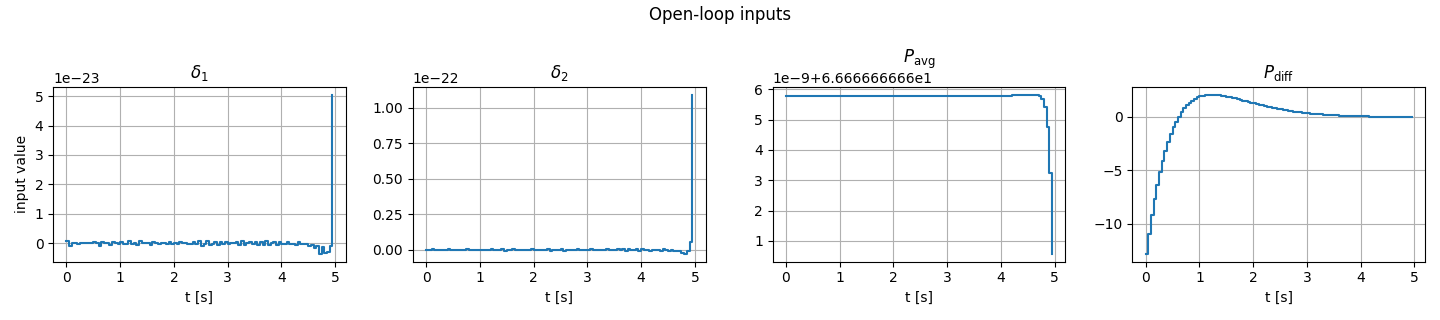

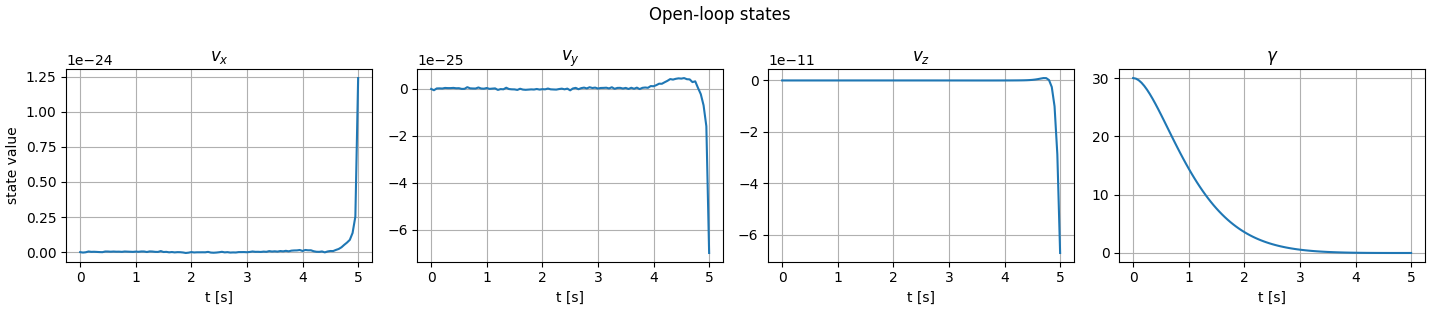

In [4]:
# total system open-loop trajectory for stationnary x_0

omega_x0 = 0; omega_y0 = 0; omega_z0 = 0; alpha0 = 0; beta0 = 0; gamma0 = np.deg2rad(30); v_x0 = 0; v_y0 = 0; v_z0 = 0 # stationnary + 30° roll angle
x0 = np.array([omega_x0, omega_y0, omega_z0, alpha0, beta0, gamma0, v_x0, v_y0, v_z0])  # initial states, must not contain the positions !

u0_ol, x_ol, u_ol, t_ol = mpc.get_u(t0, x0)

vis.animate(t_ol[:-1], x_ol[:, :-1], u_ol)

# Like above : Roll out plant by implementing the SAME open-loop inputs as above so as to compute the state vector with positions
x0_full = np.zeros(12)
x0_full[:9] = x0

X_sim = np.zeros((12, u_ol.shape[1] + 1))
X_sim[:, 0] = x0_full
for k in range(u_ol.shape[1]):
    X_sim[:, k+1] = rocket.simulate_step(X_sim[:, k], Ts, u_ol[:, k], method="linear")
T_sim = np.arange(u_ol.shape[1]) * Ts
vis.animate(T_sim, X_sim[:, :-1], u_ol)

N_cmp = min(x_ol.shape[1], X_sim.shape[1])

err = x_ol[:9, :N_cmp] - X_sim[:9, :N_cmp]

# Maximum absolute error per state
err_max = np.max(np.abs(err), axis=1)

state_names = [
    "omega_x", "omega_y", "omega_z",
    "alpha", "beta", "gamma",
    "v_x", "v_y", "v_z"
]

for name, e in zip(state_names, err_max):
    print(f"{name:8s} | max abs error = {e:.3e}")

# Plotting the open-loop trajectories
mpc.plot_trajectories(
    t_ol,
    x_ol,
    u_ol,
)

Subsystem x: 

Input upper bounds are [0.26179939]
Input lower bounds are [-0.26179939]
State upper bounds are [50.          0.17453293 50.        ]
State lower bounds are [-50.          -0.17453293 -50.        ] 

Not yet convgerged at iteration 1
Not yet convgerged at iteration 2
Not yet convgerged at iteration 3
Not yet convgerged at iteration 4
Not yet convgerged at iteration 5
Not yet convgerged at iteration 6
Not yet convgerged at iteration 7
Not yet convgerged at iteration 8
Maximum invariant set found after 9 iterations !

Subsystem y: 

Input upper bounds are [0.26179939]
Input lower bounds are [-0.26179939]
State upper bounds are [50.          0.17453293 50.        ]
State lower bounds are [-50.          -0.17453293 -50.        ] 

Not yet convgerged at iteration 1
Not yet convgerged at iteration 2
Not yet convgerged at iteration 3
Not yet convgerged at iteration 4
Not yet convgerged at iteration 5
Not yet convgerged at iteration 6
Not yet convgerged at iteration 7
Not yet co

c:\Users\vince\anaconda3\envs\mpc2025\Lib\site-packages\cvxpy\reductions\solvers\solving_chain_utils.py:30: UserWarning: The problem includes expressions that don't support CPP backend. Defaulting to the SCIPY backend for canonicalization.
  warnings.warn(UserWarning(



Simulating time 0.05: 
Simulating time 0.10: 
Simulating time 0.15: 
Simulating time 0.20: 
Simulating time 0.25: 
Simulating time 0.30: 
Simulating time 0.35: 
Simulating time 0.40: 
Simulating time 0.45: 
Simulating time 0.50: 
Simulating time 0.55: 
Simulating time 0.60: 
Simulating time 0.65: 
Simulating time 0.70: 
Simulating time 0.75: 
Simulating time 0.80: 
Simulating time 0.85: 
Simulating time 0.90: 
Simulating time 0.95: 
Simulating time 1.00: 
Simulating time 1.05: 
Simulating time 1.10: 
Simulating time 1.15: 
Simulating time 1.20: 
Simulating time 1.25: 
Simulating time 1.30: 
Simulating time 1.35: 
Simulating time 1.40: 
Simulating time 1.45: 
Simulating time 1.50: 
Simulating time 1.55: 
Simulating time 1.60: 
Simulating time 1.65: 
Simulating time 1.70: 
Simulating time 1.75: 
Simulating time 1.80: 
Simulating time 1.85: 
Simulating time 1.90: 
Simulating time 1.95: 
Simulating time 2.00: 
Simulating time 2.05: 
Simulating time 2.10: 
Simulating time 2.15: 
Simulating

AppLayout(children=(HBox(children=(Play(value=0, description='Press play', max=299, step=2), IntSlider(value=0…

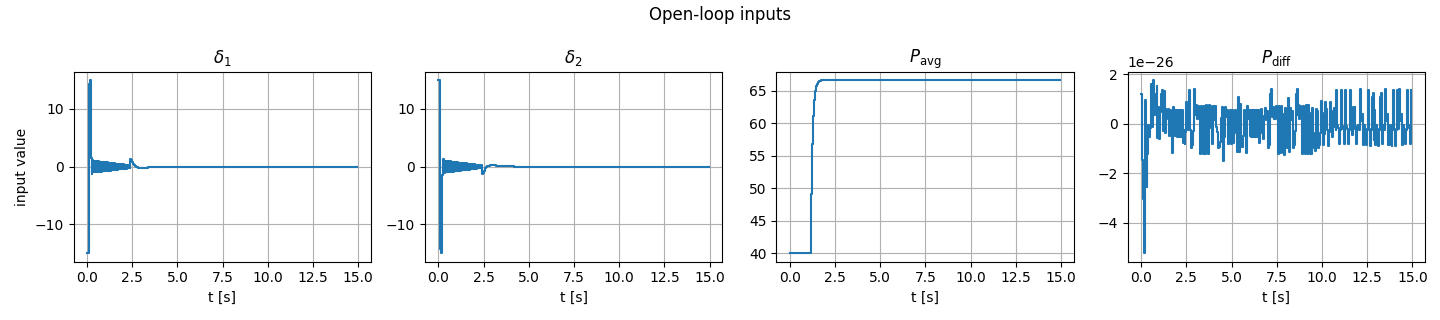

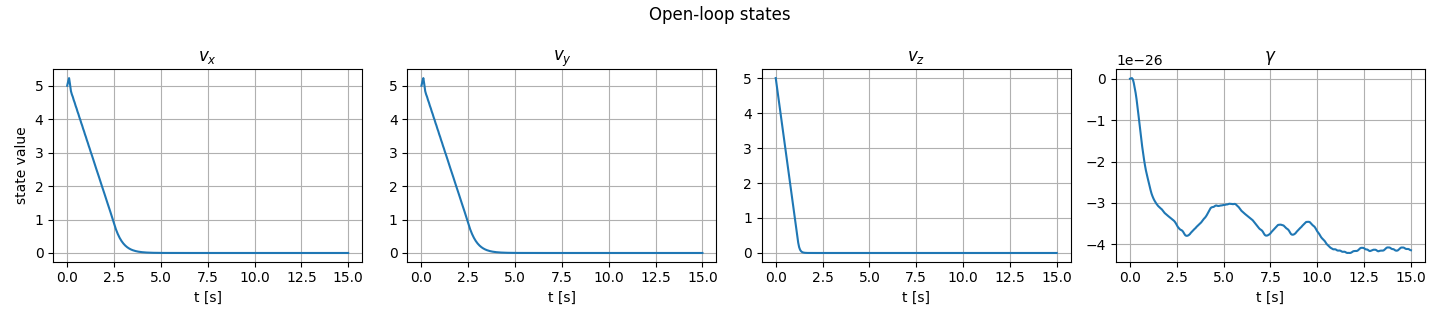

In [5]:
# closed-loop trajectory for non-stationnary x0

omega_x0 = 0; omega_y0 = 0; omega_z0 = 0; alpha0 = 0; beta0 = 0; gamma0 = 0; v_x0 = 5; v_y0 = 5; v_z0 = 5 # 5 m/s + no roll angle
x0 = np.array([omega_x0, omega_y0, omega_z0, alpha0, beta0, gamma0, v_x0, v_y0, v_z0])  # initial states, must not contain the positions !

x0_full = np.zeros(12)
x0_full[:9] = x0

mpc = MPCVelControl().new_controller(rocket, Ts, H)
t_cl, x_cl, u_cl, t_ol, x_ol, u_ol, _ = rocket.simulate_control(
    mpc, sim_time, H, x0_full, method="linear"
)

vis = RocketVis(rocket, rocket_obj_path)
vis.anim_rate = 1.0
vis.animate(t_cl[:-1], x_cl[:, :-1], u_cl, T_ol=t_ol[..., :-1], X_ol=x_ol, U_ol=u_ol)

# Plotting the closed-loop trajectories
mpc.plot_trajectories(
    t_cl,
    x_cl,
    u_cl,
)



Subsystem x: 

Input upper bounds are [0.26179939]
Input lower bounds are [-0.26179939]
State upper bounds are [50.          0.17453293 50.        ]
State lower bounds are [-50.          -0.17453293 -50.        ] 

Not yet convgerged at iteration 1
Not yet convgerged at iteration 2
Not yet convgerged at iteration 3
Not yet convgerged at iteration 4
Not yet convgerged at iteration 5
Not yet convgerged at iteration 6
Not yet convgerged at iteration 7
Not yet convgerged at iteration 8
Maximum invariant set found after 9 iterations !

Subsystem y: 

Input upper bounds are [0.26179939]
Input lower bounds are [-0.26179939]
State upper bounds are [50.          0.17453293 50.        ]
State lower bounds are [-50.          -0.17453293 -50.        ] 

Not yet convgerged at iteration 1
Not yet convgerged at iteration 2
Not yet convgerged at iteration 3
Not yet convgerged at iteration 4
Not yet convgerged at iteration 5
Not yet convgerged at iteration 6
Not yet convgerged at iteration 7
Not yet co

AppLayout(children=(HBox(children=(Play(value=0, description='Press play', max=299, step=2), IntSlider(value=0…

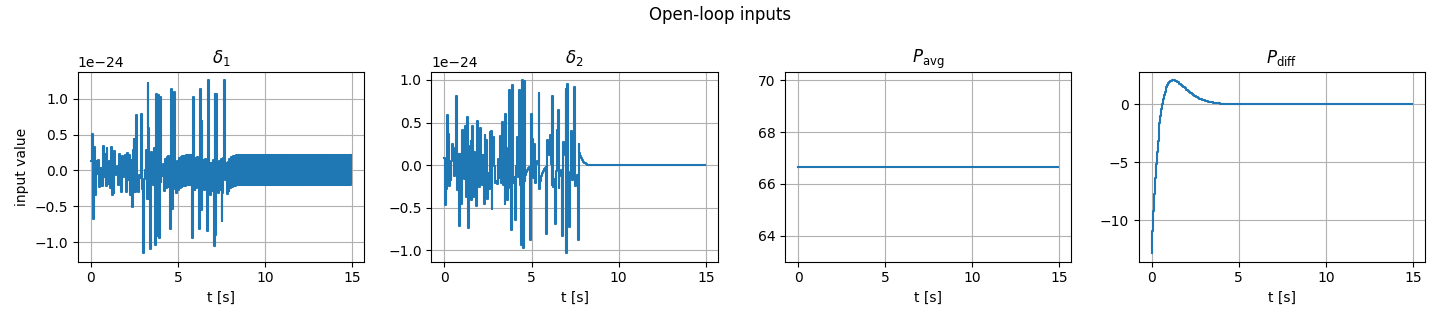

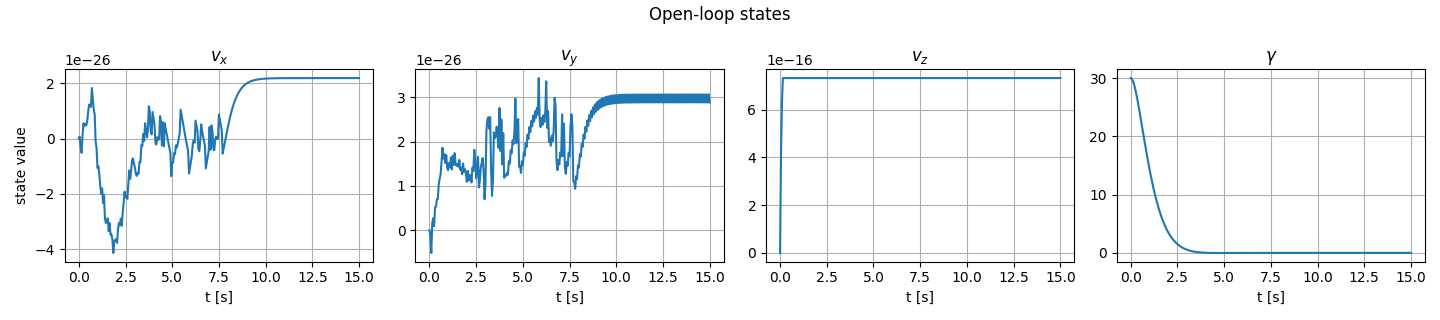

In [6]:
# closed-loop trajectory for stationnary x0
omega_x0 = 0; omega_y0 = 0; omega_z0 = 0; alpha0 = 0; beta0 = 0; gamma0 = np.deg2rad(30); v_x0 = 0; v_y0 = 0; v_z0 = 0 # stationnary + 30° roll angle
x0 = np.array([omega_x0, omega_y0, omega_z0, alpha0, beta0, gamma0, v_x0, v_y0, v_z0])  # initial states, must not contain the positions !

x0_full = np.zeros(12)
x0_full[:9] = x0

mpc = MPCVelControl().new_controller(rocket, Ts, H)
t_cl, x_cl, u_cl, t_ol, x_ol, u_ol, _ = rocket.simulate_control(
    mpc, sim_time, H, x0_full, method="linear"
)

vis = RocketVis(rocket, rocket_obj_path)
vis.anim_rate = 1.0
vis.animate(t_cl[:-1], x_cl[:, :-1], u_cl, T_ol=t_ol[..., :-1], X_ol=x_ol, U_ol=u_ol)

# Plotting the closed-loop trajectories
mpc.plot_trajectories(
    t_cl,
    x_cl,
    u_cl,
)